# Linear Regression

## 1. Introduction

### 1.1 Abstract

In this exercise, we illustrate Hoeffding's inequality in the context of virtual coin flips.

### 1.2 Hoeffding's Inequality for a Single Bin

For an infinite bin, from which we pick a sample of size $N$, we can calculate the probability bounds between the sample frequency, $\nu$, and unknown the bin frequency, $\mu$ via [Hoeffding's Inequality](https://en.wikipedia.org/wiki/Hoeffding%27s_inequality):

$$\mathbb{P} \left[ \left| \nu - \mu \right| > \epsilon \right] \le 2e^{-2\epsilon^2 N}$$

It is valid for all $N$ and $\epsilon$ and the bound does not depend on $\mu$.  It illustrates the tradeoff between $N$, $\epsilon$, and the bound.

### 1.3 Libraries

The Python libraries used are:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import multiprocessing as mp
import itertools
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75,nanstr='nan',precision=4,suppress=False,threshold=500,formatter=None)
%matplotlib inline

## 2. Virtual Coin Flips

### 2.1 Mean Frequency of "Obtaining a Head" for Three Coins

In this virtual experiment, 1000 fair coins are simulated.  Each coin is flipped 10 times.  The data is stored in a matrix where the 10 columns represent each of the 10 flips and the 1000 rows represent the 1000 individual coins.

It is assumed that 'heads' are represented by '1' and 'tails' are represented by '0', so that we can use `np.sum(..., axis=1)` to get the number of heads for each coin.

A total of three coins are selected from the 1000 fair coins - $c_1$ is the first coin, $c_{rand}$ is a random coin, and $c_{min}$ is the coin that yielded the minimum number of heads (out of the 10 coin flips).  The following code calculates the mean frequency of "obtaining a head" for each of these three coins.

In [2]:
def get_coin_flip_data():
    c       = np.random.randint(2,size=(1000,10))
    idx     = np.random.choice(1000)   # choose index for a random coin
    n_heads = np.sum(c,axis=1)         # calculate the number of heads
    lo      = np.argmin(n_heads)       # find first argument with smallest number of heads

    c_1     = c[0,:]                   # choose the first coin
    c_rand  = c[idx,:]                 # choose a random coin
    c_min   = c[lo,:]                  # choose the coin with the minimum number of heads
    
    ν_1     = np.mean(c_1)             # get the fraction of heads for first coin
    ν_rand  = np.mean(c_rand)          # get the fraction of heads for random coin
    ν_min   = np.mean(c_min)           # get the fraction of heads for coin with minimum number of heads
    return ν_1, ν_rand, ν_min

In [3]:
def run_experiment(N=100000,seed=None,verbose=False):
    if seed is not None:
        np.random.seed(seed)
    sum_ν_1    = 0.0
    sum_ν_rand = 0.0
    sum_ν_min  = 0.0
    for i in range(N):
        ν_1, ν_rand, ν_min = get_coin_flip_data()
        sum_ν_1    += ν_1
        sum_ν_rand += ν_rand
        sum_ν_min  += ν_min

    mean_ν_1    = sum_ν_1/N
    mean_ν_rand = sum_ν_rand/N
    mean_ν_min  = sum_ν_min/N

    if verbose is True:
        print("Mean ν_1    = {}".format(mean_ν_1))
        print("Mean ν_rand = {}".format(mean_ν_rand))
        print("Mean ν_min  = {}".format(mean_ν_min))

    return mean_ν_min

In [4]:
def run_experiment_parallel(N=100000,verbose=False):
    n_cpus = mp.cpu_count()//2
    experiments = list(itertools.repeat(N//n_cpus,n_cpus))
    #Note that this makes an assumption that the different seeds
    #will generate independent random streams; this may not be true.
    seeds = np.random.choice(N,n_cpus,replace=False)
    p = mp.Pool(n_cpus)
    ν_arr = p.starmap(run_experiment,zip(experiments,seeds,itertools.repeat(False)))
    ν_arr = np.array(ν_arr)
    if verbose is True:
        print(ν_arr)
    return np.mean(ν_arr)

In [5]:
# Takes about 10 seconds for N=100k: [0.037, 0.0374, 0.0376, 0.0378]
# %time run_experiment(N=100000)
%time run_experiment_parallel(verbose=True)

[ 0.0375  0.0378  0.0377  0.0374]
CPU times: user 11 ms, sys: 9.77 ms, total: 20.7 ms
Wall time: 2.97 s


0.03762100000000581

### 2.2 Which coin(s) have a mean that satisfy Hoeffding's Inequality?

The coins with a distribution of $\nu$ that satisfies the (single-bin) Hoeffding Inequality are $c_1$ and $c_{rand}$ because their means, $\nu_1, \nu_{rand}$ are close to 0.5, while $\nu_{min}$ is **not** close to 0.5.

To get the probability bounds that $\nu$ will be close to the bin frequency (within a certain tolerance, $\epsilon$, the following function can be used:

In [6]:
def get_probability_bounds(epsilon=0.02,N=100000):
    return 2.0 * np.exp(-2.0*epsilon*epsilon*N)

get_probability_bounds(epsilon=0.02,N=20000)

2.2507034943851823e-07

Here, it can be seen that the probability that $\nu$ is **not** within $\epsilon$=0.01 of the bin frequency, 0.5, is extremely low.

## 3. Error and Noise

### 3.1 Background

Let us consider a target function, $y=f\left(\mathbf{x}\right)$.  The effect of noise is that for a given input, $\mathbf{x}$, it is possible to get multiple values of $y$.  In order to take into account the effects of noise, the *target function* is replaced by a *target distribution*, which we shall call $\mathbb{P}(y | \mathbf{x})$.

Hence, the sample points, $(\mathbf{x},y)$, are now generated via the joint distribution:

$$\mathbb{P}(\mathbf{x})\mathbb{P}(y|\mathbf{x}) \equiv \mathbb{P}(\mathbf{x},y)$$

where $\mathbb{P}(\mathbf{x})$ is the *input distribution*, and $\mathbb{P}(y|\mathbf{x})$ is the *target distribution*.

### 3.2 Example

Suppose $h, f$ are binary functions and we observe that the hypothesis, $h$, has a probability, $\mu$, of making an error when approximating the target function, $f$.

The input distribution arises from this observation and we can write this as:

$$\mathbb{P}(\mathbf{x}) = \left\{ \begin{array}{rl}
    \mu & h \ne f(x)\\
1 - \mu & h = f(x)
\end{array}\right.$$

Suppose "noise" is added to $f$ in the following manner:

$$\mathbb{P}(y|\mathbf{x}) = \left\{ \begin{array}{rl}
  \lambda & y = f(x)\\
1-\lambda & y \ne f(x)
\end{array}\right.$$

We now wish to calculate the probability of error that $h$ makes in approximating $y$.  There are two ways for this to happen: the first is for the top event of the two equations above to occur, the second is for the bottom event of the two equations above to occur.  The probability of error is therefore:

$$\mu \lambda + \left(1 - \mu\right)\left(1 - \lambda\right)$$

In the case of $\lambda = \frac{1}{2}$, the above expression becomes:

$$\tfrac{1}{2} \mu + \tfrac{1}{2} \left(1 - \mu\right) = \tfrac{1}{2}$$

which is independent of $\mu$.

## 4. Linear Regression

### 4.1 Generating Sample Data

#### 4.1.1 First, we generate a three-column random matrix with the first column as ones.

In [7]:
def generate_data(n,seed=None):
    if seed is not None:
        np.random.seed(seed)
    x0 = np.ones(n)
    x1 = np.random.uniform(low=-1,high=1,size=(2,n))
    return np.vstack((x0,x1)).T

#### 4.1.2 Generating a random line inside the region of interest

The region of interest is $\mathcal{X}=\left[-1,1\right] \times \left[-1,1\right]$,
where $\times$ denotes the [Cartesian Product](https://en.wikipedia.org/wiki/Cartesian_product).

To ensure that the random line falls within the region of interest, two points, $(x_0,y_0)$ and $(x_1,y_1)$ are generated within $\mathcal{X}$.

#### 4.1.3 Equation of the random line in the slope-intercept form, $y = mx + c$

$$\text{Slope, }m = \frac{y_1 - y_0}{x_1 - x_0}$$

$$\text{Intercept, }c = y_0 - m x_0$$

#### 4.1.4 Equation of the random line in hypothesis [weights] form

The hypothesis is given by:

$$h(\mathbf{x}) = \text{sign}(\mathbf{w^T x}) = \text{sign}\left(\sum_{i=0}^N w_i x_i\right)$$

We now consider the two dimensional case ($N=2$), and note that $x_0=1$.  The decision boundary is $h(\mathbf{x})$=0, which can be converted to the slope-intercept form if we take $x_1$ to be the $x$ axis, and $x_2$ to be the $y$ axis, i.e.:

$$y = - \frac{w_1}{w_2} x - \frac{w_0}{w_2}$$

Comparison with the equation $y = mx + c$ yields the following relationships:

$$m = - \frac{w_1}{w_2},\quad c = - \frac{w_0}{w_2}$$

If we arbitrarily set $w_2=1$, we arrive at the following set of weights, which is consistent with the decision boundary denoted by $y = mx + c$:

$$\mathbf{w} = \left(-c,-m,1\right)$$

In [8]:
def get_random_line(seed=None):
    X = generate_data(2,seed=seed)
    x = X[:,1]
    y = X[:,2]
    m = (y[1]-y[0])/(x[1]-x[0])
    c = y[0] - m*x[0]
    return np.array([-c,-m,1])

def draw_line(ax,w,marker='g--',label=None):
    m = -w[1]/w[2]
    c = -w[0]/w[2]
    x = np.linspace(-1,1,20)
    y = m*x + c
    if label is None:
        ax.plot(x,y,marker)
    else:
        ax.plot(x,y,marker,label=label)
        
def get_hypothesis(X,w):
    return np.sign(np.dot(X,w))

### 4.2 Plotting the Training Data

The following code plots the training dataset

In [9]:
def plot_data(fig,plot_id,X,y=None,w_arr=None,my_x=None,title=None):
    ax = fig.add_subplot(plot_id)
    if y is None:
        ax.plot(X[:,1],X[:,2],'gx')
    else:
        ax.plot(X[y > 0,1],X[y > 0,2],'b+',label='Positive (+)')
        ax.plot(X[y < 0,1],X[y < 0,2],'ro',label='Negative (-)')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.grid(True)
    if w_arr is not None:
        if isinstance(w_arr,list) is not True:
            w_arr=[w_arr]
        for i,w in enumerate(w_arr):
            if i==0:
                draw_line(ax,w,'g-',label='Theoretical')
            else:
                draw_line(ax,w,'g--')
    if my_x is not None:
        ax.plot([my_x[0]],[my_x[1]],'kx',markersize=10)
    if title is not None:
        ax.set_title(title)
    ax.legend(loc='best',frameon=True)

### 4.3 Creating a Dataset with a Decision Boundary Fitted by Linear Regression

The weights for the decision boundary may be calculated using [linear regression](https://en.wikipedia.org/wiki/Linear_regression) with an appropriate estimator.  We start with a "cost function", where in this case we choose the *in-sample* squared error, i.e.:

$$E_{in}(h)=\frac{1}{N}\sum_{i=1}^N
\left(h(\mathbf{x_i})-y_n\right)^2$$
$$E_{in}(\mathbf{w})=\frac{1}{N}\sum_{i=1}^N
\left(\mathbf{w^T x_i}-y_n\right)^2 = \frac{1}{N} \| \mathbf{Xw - y} \|^2$$

The in-sample error is minimized as follows:

$$\nabla E_{in}(\mathbf{w}) = \frac{2}{N}\mathbf{X^T}\left(\mathbf{X w - y}\right) = 0$$

$$\mathbf{X^T X w} = \mathbf{X^T y}$$

$$\mathbf{w} = \left(\mathbf{X^T X}\right)^{-1}\mathbf{X^T y}$$

We thus arrive at the following, which is also called the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS) estimator:

$$w = \left(\mathbf{X^T X}\right)^{-1}\mathbf{X^T y} = \mathbf{X^\dagger}y$$

where in the last step, we have introduced the [Moore–Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore–Penrose_pseudoinverse):

$$\mathbf{X^\dagger} = \left(\mathbf{X^T X}\right)^{-1}\mathbf{X^T}$$

This is implemented via the following line of code in the subroutine below:

`w_linreg = np.dot(np.linalg.pinv(X),y)`

In [10]:
def create_dataset(N,make_plot=True,seed=None):
    X = generate_data(N,seed=seed)
    w_theoretical = get_random_line()
    y = get_hypothesis(X,w_theoretical)
    w_linreg = np.dot(np.linalg.pinv(X),y)
    if make_plot is True:
        fig = plt.figure(figsize=(7,5))
        plot_data(fig,111,X,y,[w_theoretical,w_linreg],
                  title="Initial Dataset")
    return X,y,w_theoretical,w_linreg

### 4.4 Evaluating the Decision Boundary via the Misclassification Error

If we know the theoretical decision boundary, `w_theoretical`, that 'knows' the correct classification of points, we can calculate the number of points misclassified by `w` (the weights calculated using linear regression) via a [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) approach (random sampling).

In [11]:
def calculate_misclassification(w_theoretical,w,n_samples=1000,verbose=True):
    X  = generate_data(n_samples,seed=None)
    y0 = get_hypothesis(X,w_theoretical)
    y  = get_hypothesis(X,w)
    n_correct = np.sum(y == y0)
    return (n_samples-n_correct)/n_samples

### 4.5 Estimating the misclassification error by taking an average over many 'experiments'

We choose $N$=100, and to do 1000 'experiments'.

In [12]:
def misclassification_runs(N=100,n_expts=1000):
    m_in_arr = list()
    m_out_arr = list()
    for i in range(n_expts):
        w_theoretical = get_random_line()

        X_in = generate_data(N,seed=None)
        y_in = get_hypothesis(X_in,w_theoretical)
        w_in = np.dot(np.linalg.pinv(X_in),y_in)
        m_in = calculate_misclassification(w_theoretical,w_in,n_samples=1000)
        
        X_out = generate_data(N,seed=None)
        y_out = get_hypothesis(X_out,w_theoretical)
        w_out = np.dot(np.linalg.pinv(X_out),y_out)
        m_out = calculate_misclassification(w_theoretical,w_out,n_samples=1000)

        m_in_arr.append(m_in)
        m_out_arr.append(m_in)
    return m_in_arr,m_out_arr

In [13]:
# [0.0482, 0.04727, 0.04815, 0.04858, 0.04900, 0.04890]
# [0.24319, 0.24848, 0.24765]
m_in_arr,m_out_arr = misclassification_runs()
print("Misclassification error: %.5f (in-sample)" % np.mean(m_in_arr))
print("Misclassification error: %.5f (out-of-sample)" % np.mean(m_out_arr))

Misclassification error: 0.04859 (in-sample)
Misclassification error: 0.04859 (out-of-sample)


The miclassiification error here is about ~5%.  Also, we find no difference in misclassification error between the in-sample and out-of-sample weights.

## 5. The Perceptron Learning Algorithm

### 5.1 Implementation

The Preceptron Learning Algorithm (PLA) is implemented in the following steps

1. Calculate $h\left(\mathbf{x}\right)=\text{sign}\left(\mathbf{w^T x}\right)$ which can take on values of -1, 0, or 1 for each sample.
2. Compare $h\left(\mathbf{x}\right)$ with $y$ to find misclassified point(s) if any.
3. Pick one misclassified point at random.
4. Iterate the weights according to the PLA: $w = w + y_n x_n$, where $y_n$ is the correct classification for the misclassified point, and $x_n$ is the misclassified point.

In [14]:
def PLA(w,X,y0,n_iterations=10,verbose=True):
    assert len(y0)==X.shape[0]
    n=len(y0)
    x_arr = list()
    w_arr = list()
    m_arr = list()
    for i in range(n_iterations):
        h   = get_hypothesis(X,w)
        bad = h != y0
        bad = np.argwhere(bad).flatten()
        if len(bad) > 0:
            idx  = np.random.choice(bad,1)[0]
            my_x = X[idx,:]
            m_arr.append(100.0*len(bad)/n)
            x_arr.append(my_x)
            w_arr.append(np.copy(w))
            w += np.dot(y0[idx],my_x)
            if verbose is True:
                print("iter {}: {}% misclassified, w={}" \
                      .format(i,m_arr[-1],w_arr[-1]))
        else:
            m_arr.append(0.0)
            x_arr.append(np.array([1.0, np.nan,np.nan]))
            w_arr.append(np.copy(w))
            if verbose is True:
                print("iter {}: zero misclassified (PLA has converged)".format(i))
            return w,w_arr,m_arr,x_arr
    print("PLA failed to converge after {} iterations".format(i))
    return None,None,None,None

### 5.2 Using the Linear Regression weights as an 'initial guess' for the PLA

If the weights obtained from linear regression are used as an 'initial guess' for the Perceptron Learning Algorithm (PLA), we can reduce the average number of required iterations down to about 4~5, as the following code shows:

In [15]:
def get_iteration_distribution(N,n_trials=1000,max_iterations=10000,summary=True):
    n_iterations=np.zeros(n_trials,dtype=int)
    for i in range(n_trials):
        X,y,w_theoretical,w_linreg = create_dataset(N=N,make_plot=False,seed=None)
        w,w_arr,m_arr,x_arr = PLA(w_linreg,X,y,n_iterations=max_iterations,verbose=False)
        n_iterations[i]=len(w_arr)
        
    if summary is True:
        print("Minumum iterations: {}".format(np.min(n_iterations)))
        print("Maximum iterations: {}".format(np.max(n_iterations)))
        print("Mean    iterations: {}".format(np.mean(n_iterations)))
    return n_iterations

In [16]:
# [4.721, 5.88, 4.8, 5.31, 6.237]
n_iterations = get_iteration_distribution(N=10)

Minumum iterations: 1
Maximum iterations: 194
Mean    iterations: 5.31


## 6. Non-Linear Transformations

### 6.1 Background
Consider the target function, which we implement below:

$$f(x_1,x_2) = \text{sign}\left(x_1^2 + x_2^2 - 0.6\right)$$

In [17]:
def get_nonlinear_hypothesis(X):
    h = X[:,1]**2 + X[:,2]**2 - 0.6
    return np.sign(h).astype(int)

A non-linear dataset based on the above target function, but with 10% of the samples 'flipped' in sign is generated via the code below.


### 6.2 Misclassification Error (Linear Decision Boundary)

We can see that, using a linear decision boundary, the misclassification error is high, about ~50%.

In [18]:
def create_nonlinear_dataset(N=1000,make_plot=True,seed=None,verbose=False):
    X  = generate_data(N,seed=seed)
    y0 = get_nonlinear_hypothesis(X)
    idx = np.random.choice(len(y0),100,replace=False)  # flip 100
    y_flipped = np.copy(y0)                            # random
    y_flipped[idx] = -y0[idx]                          # indices
    w_linreg = np.dot(np.linalg.pinv(X),y_flipped)
    y_linreg = get_hypothesis(X,w_linreg)
    if verbose is True:
        print("w (from linear regression) = {}".format(w_linreg))
        print("y (from linear regression) = {}".format(y_linreg))
    if make_plot is True:
        fig = plt.figure(figsize=(7,5))
        plot_data(fig,111,X,y_flipped,[np.array([10,-1,1]), w_linreg],
                  title="Initial Dataset")
    return y_flipped,y_linreg

w (from linear regression) = [ 0.0939  0.0293  0.014 ]
y (from linear regression) = [ 1.  1.  1. ...,  1.  1.  1.]


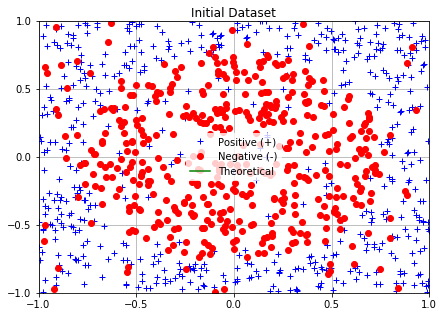

In [19]:
y0,y_linreg = create_nonlinear_dataset(verbose=True)

In [20]:
def run_trials_nonlinear(N=1000,n_trials=1000,verbose=True):
    m_arr = list()
    for i in range(n_trials):
        y0,y = create_nonlinear_dataset(N=N,make_plot=False,seed=None)
        n_correct = np.sum(y == y0)
        m_arr.append((N-n_correct)/N)
    if verbose is True:
        print("Minimum misclassification= {}".format(np.min(m_arr)))
        print("Maximum misclassification= {}".format(np.max(m_arr)))
        print("Average misclassification= {}".format(np.mean(m_arr)))
    return m_arr

In [21]:
m_arr = run_trials_nonlinear()

Minimum misclassification= 0.383
Maximum misclassification= 0.605
Average misclassification= 0.50277


### 6.3 Misclassification Error (Nonlinear Decision Boundary)

By changing to a nonlinear decision boundary, the misclassification error can be considerably reduced.  The original dataset, $(x_1, x_2)$ is replaced by a new dataset, $(x_1, x_2, x_3, x_4, x_5) = (x_1, x_2, x_1 x_2, x_1^2, x_2^2)$, where we have added the last 3 columns via nonlinear transformations on the original data.

In [22]:
def add_nonlinear_features(X):
    N = X.shape[0]
    X = np.hstack((X,np.zeros((N,3))))
    X[:,3] = X[:,1]*X[:,2]
    X[:,4] = X[:,1]**2
    X[:,5] = X[:,2]**2
    return(X)

In [23]:
def create_nonlinear_dataset_v2(N=1000,make_plot=True,seed=None,verbose=False):
    X  = generate_data(N,seed=seed)
    y0 = get_nonlinear_hypothesis(X)
    idx = np.random.choice(len(y0),100,replace=False)  # flip 100
    y_flipped = np.copy(y0)                            # random
    y_flipped[idx] = -y0[idx]                          # indices

    X  = add_nonlinear_features(X)
    w_linreg = np.dot(np.linalg.pinv(X),y_flipped)
    y_linreg = get_hypothesis(X,w_linreg)
    if verbose is True:
        print("w (from linear regression) = {}".format(w_linreg))
        print("y (from linear regression) = {}".format(y_linreg))
    if make_plot is True:
        fig = plt.figure(figsize=(7,5))
        plot_data(fig,111,X,y_flipped,title="Initial Dataset")
    return y_flipped,y_linreg,X

In [24]:
def plot_data_nonlinear(fig,plot_id,X,y=None,w_arr=None,w_colors=None,title=None):
    p = 1.5
    ax = fig.add_subplot(plot_id)
    if y is None:
        ax.plot(X[:,1],X[:,2],'gx')
    else:
        ax.plot(X[y > 0,1],X[y > 0,2],'b+',label='Positive (+)')
        ax.plot(X[y < 0,1],X[y < 0,2],'r_',label='Negative (-)')
    ax.set_xlim(-p,p)
    ax.set_ylim(-p,p)
    ax.grid(True)
    if w_arr is not None and w_colors is not None:
        if isinstance(w_arr,list) is not True:
            w_arr=[w_arr]
        x1 = np.linspace(-p,p,100)
        x2 = np.linspace(-p,p,100)
        X1,X2 = np.meshgrid(x1,x2)
        X1X2 = X1*X2
        X1_sq= X1**2
        X2_sq= X2**2
        labels = ['(a)','(b)','(c)','(d)','(e)']
        for i,w in enumerate(w_arr):
            Y = w[0] + w[1]*X1 + w[2]*X2 + w[3]*X1X2 + \
                w[4]*X1_sq + w[5]*X2_sq
            cp = ax.contour(X1,X2,Y,1,linewidth=4, levels=[0.0],
                             linestyles='dashed', colors=w_colors[i], 
                             label=labels[i])
            ax.clabel(cp, inline=True, fontsize=14)
    if title is not None:
        ax.set_title(title)
    ax.legend(loc='best',frameon=True)

In [25]:
N = 1000
y0,y,X = create_nonlinear_dataset_v2(N=N,make_plot=False,seed=None)
n_correct = np.sum(y == y0)
m = (N-n_correct)/N
print(m)

0.133


By using a nonlinear decision boundary, the misclassification error has gone down to about ~12%.

In [26]:
def get_nonlinear_misclass(n_trials=1000,verbose=True):
    m_arr = list()
    for i in range(n_trials):
        y0,y,X = create_nonlinear_dataset_v2(N=N,make_plot=False,seed=None)
        n_correct = np.sum(y == y0)
        m_arr.append((N-n_correct)/N)
    if verbose is True:
        print("Minimum misclassification= {}".format(np.min(m_arr)))
        print("Maximum misclassification= {}".format(np.max(m_arr)))
        print("Average misclassification= {}".format(np.mean(m_arr)))        
    return m_arr

In [27]:
m_arr = get_nonlinear_misclass()

Minimum misclassification= 0.102
Maximum misclassification= 0.159
Average misclassification= 0.12403


With repeated trials of 1000 Monte-Carlo simulations, the misclassification error remains at roughly ~12%.  A histogram shows the probability distribution of the misclassification error.

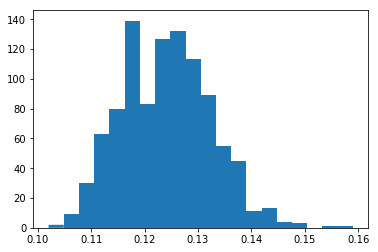

In [28]:
_ = plt.hist(m_arr,bins=20)

### 6.4 Evaluation of 5 Possible Hypotheses

Here, we introduce 5 possible hypotheses (via their 'weights') to test their misclassification error.

In [29]:
w1 = np.array([-1,-0.05,0.08,0.13,1.50,1.5])
w2 = np.array([-1,-0.05,0.08,0.13,1.50,15.0])
w3 = np.array([-1,-0.05,0.08,0.13,15.0,1.5])
w4 = np.array([-1,-1.50,0.08,0.13,0.05,0.05])
w5 = np.array([-1,-0.05,0.08,0.13,0.15,0.15])
w_arr = [w1,w2,w3,w4,w5]
w_colors = ['red','orange','green','blue','pink']

Apparently, there is little necessity to perform a Monte-Carlo simulation to calculate their misclassification error.  A contour plot of the above 5 weights (decision boundary at 'zero' plotted as dotted lines) clearly shows that red line ($w_1$) as the best performing hypothesis.

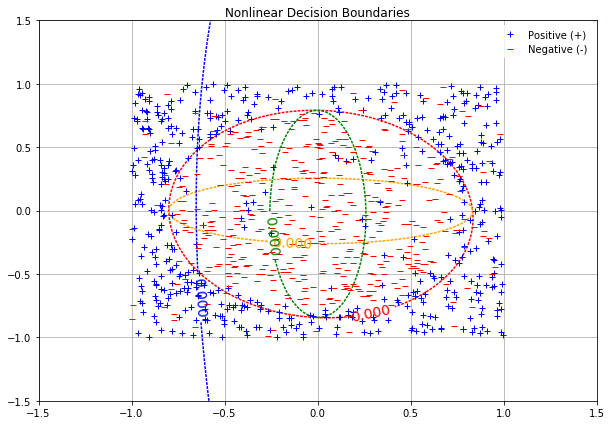

In [30]:
fig = plt.figure(figsize=(10,7))
plot_data_nonlinear(fig,111,X,y0,w_arr,w_colors,"Nonlinear Decision Boundaries")